<a href="https://colab.research.google.com/github/arezyhs/Python-Digital-Image-Processing-Projects/blob/main/PCD-Voting-Based-Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voting-Based Document Image Skew Detection**

## Anggota:
1. **Akbar Rezy Hanara Setiyawan** - 23051204335  
2. **Sakti Maulana Hidayatullah** - 23051204322

## Referensi Artikel Jurnal:
Boiangiu, C.-A., Dinu, O.-A., Popescu, C., Constantin, N., & Petrescu, C. (2020).  
**Voting-Based Document Image Skew Detection**. *Applied Sciences*, **10**(7), 2236.  
[https://doi.org/10.3390/app10072236](https://doi.org/10.3390/app10072236)

## Dataset:
Dataset gambar dokumen dengan kemiringan (skew) yang digunakan untuk uji coba program diambil dari situs Kaggle:  
📂 [Kaggle - rdocuments](https://www.kaggle.com/datasets/vishnunkumar/rdocuments/data). Dataset ini berisi sekitar **950 gambar dokumen** yang memiliki kemiringan (skew).

## Alur Program
- INPUT GAMBAR DAN PREPROCESSING GAMBAR (GRAYSCALE + BINERISASI)
- METODE 1 DETEKSI KEMIRINGAN DENGAN FFT
- METODE 2 PROJECTION PROFILING
- METODE 3 DETEKSI GARIS DENGAN HOUGH TRANSFORM
- VOTING HASIL TERBAIK DI ANTARA TIGA METODE
- OUTPUT HASIL DAN GAMBAR TERBAIK YANG TERKOREKSI

In [79]:
# Import libraries
from google.colab import files
from IPython.display import display, HTML
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate # memutar gambar secara digital
from skimage.filters import threshold_otsu, sobel # pemrosesan citra dari pustaka skimage
from skimage.color import rgb2gray # gambar RGB menjadi grayscale
from skimage import exposure, measure, morphology # manipulasi eksposur gambar, pengukuran bentuk, morfologi, dll
from skimage.transform import hough_line, hough_line_peaks, radon # transformasi garis Hough dan Radon
from skimage.util import img_as_ubyte # gambar menjadi format byte 8-bit
import cv2 # untuk pemrosesan citra tingkat lanjut
import math

Saving Image-9-22Image_9.jpg to Image-9-22Image_9.jpg


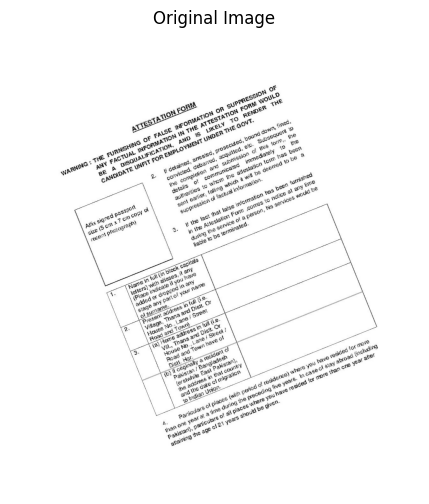

In [80]:
# unggah gambar
uploaded = files.upload()
image_path = next(iter(uploaded))
img_pil = Image.open(io.BytesIO(uploaded[image_path])).convert("RGB")
img = np.array(img_pil)

# tampilkan gambar upload
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Pra-Proses Gambar untuk Pengolahan Citra Digital
## Konversi ke Grayscale

**Tujuan**:  
Mengubah gambar berwarna (RGB) menjadi grayscale (abu-abu) untuk menyederhanakan analisis dengan mengurangi 3 saluran warna menjadi 1 saluran intensitas.

**Keterangan**:
- Gambar asli memiliki 3 channel (Red, Green, Blue) jika berwarna
- Setelah konversi, hanya memiliki 1 channel intensitas (0=hitam, 1=putih)
- Nilai intensitas berupa angka desimal antara 0.0 sampai 1.0

**Output**:
- Menampilkan dimensi gambar hasil konversi
- Menampilkan contoh nilai intensitas piksel dari baris pertama gambar

## Binarisasi dengan Metode Otsu
**Tujuan**:  
Mengubah gambar grayscale menjadi gambar biner (hitam-putih) untuk memisahkan objek dari latar belakang.

**Proses Otsu**:
1. Metode ini secara otomatis menghitung nilai ambang (threshold) optimal
2. Ambang dipilih untuk memaksimalkan variasi antar kelas objek dan latar belakang
3. Hasil threshold ditampilkan dengan presisi 4 angka desimal

**Hasil Binerisasi**:
- Piksel lebih gelap dari threshold menjadi objek (True/1)
- Piksel lebih terang menjadi latar belakang (False/0)
- Output ditampilkan dalam bentuk array 0 dan 1 untuk memudahkan pembacaan

In [81]:
# === PRA-PROSES GAMBAR ===

# Konversi gambar ke grayscale
# Tujuan: menyederhanakan gambar dengan mengurangi saluran warna (R, G, B) menjadi satu saluran intensitas (abu-abu).
img_gray = rgb2gray(img) if img.ndim == 3 else img

print(f"[INFO] Dimensi gambar grayscale: {img_gray.shape}")
# contoh nilai intensitas piksel dari baris pertama untuk melihat bentuk datanya
print(f"[INFO] Nilai intensitas piksel:\n{img_gray}")

# Binarisasi gambar menggunakan metode Otsu
# Metode Otsu akan secara otomatis menghitung nilai ambang optimal untuk memisahkan objek dan latar belakang
thresh = threshold_otsu(img_gray)
print(f"[INFO] Nilai ambang Otsu yang terdeteksi: {thresh:.4f}")

# Buat gambar biner berdasarkan ambang tersebut
# Piksel yang lebih gelap dari ambang dianggap bagian dari objek (True), sisanya dianggap latar belakang (False)
binary_img = img_gray < thresh
print(f"[INFO] Hasil binerisasi:\n{binary_img.astype(int)}")  # tampilkan sebagai 0 dan 1

[INFO] Dimensi gambar grayscale: (1450, 1284)
[INFO] Nilai intensitas piksel:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[INFO] Nilai ambang Otsu yang terdeteksi: 0.5723
[INFO] Hasil binerisasi:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


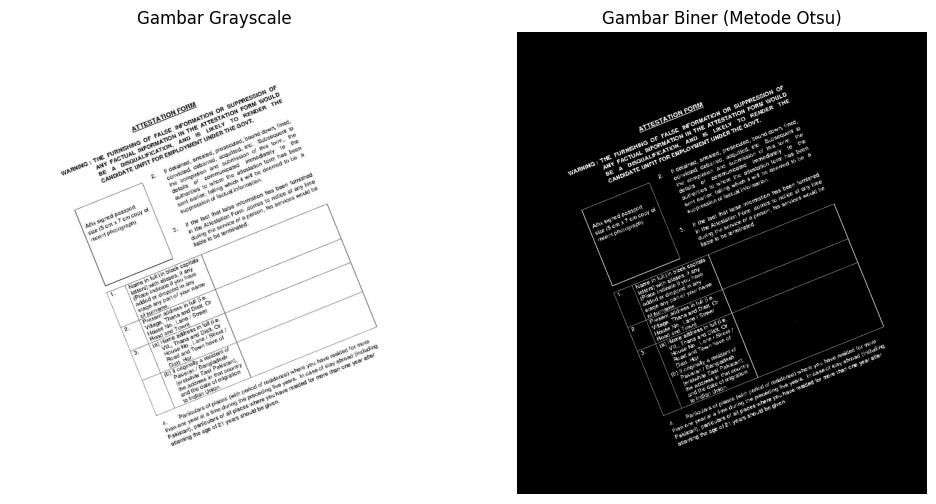

In [82]:
# === TAMPILKAN HASIL ===
plt.figure(figsize=(12, 6))

# Tampilkan gambar grayscale
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Gambar Grayscale")
plt.axis('off')

# Tampilkan gambar setelah dibinarisasi
plt.subplot(1, 2, 2)
plt.imshow(binary_img, cmap='gray')
plt.title("Gambar Biner (Metode Otsu)")
plt.axis('off')

plt.show()

# Deteksi Kemiringan Dokumen Menggunakan Transformasi Fourier (FFT)

## Konsep Dasar
Metode ini memanfaatkan analisis frekuensi untuk mengidentifikasi pola kemiringan dalam dokumen dengan langkah-langkah:

## 1. Transformasi Fourier 2D
**Tujuan**:  
Mengubah representasi gambar dari domain spasial ke domain frekuensi untuk mengidentifikasi pola periodik.

**Proses**:
- `fft2`: Melakukan transformasi Fourier cepat 2D
- `fftshift`: Memusatkan komponen frekuensi rendah
- `log1p`: Transformasi logaritmik untuk meningkatkan visibilitas spektrum

**Output**:
- Menampilkan nilai magnitudo maksimum
- Ukuran spektrum frekuensi

## 2. Peningkatan Kontras Spektrum
**Langkah Optimasi**:
1. **Rescale Intensity**: Menormalkan nilai intensitas ke range [0,1]
2. **Histogram Equalization**: Meratakan distribusi intensitas
3. **Konversi ke 8-bit**: Persiapan untuk proses binarisasi

## 3. Binarisasi dengan Otsu
**Fungsi**:  
Mengubah spektrum frekuensi menjadi gambar biner untuk memisahkan komponen penting dari noise.

**Output**:
- Nilai threshold yang terdeteksi otomatis

## 4. Transformasi Hough untuk Deteksi Garis
**Mekanisme**:
- Mengidentifikasi garis lurus dalam spektrum frekuensi
- Garis-garis ini merepresentasikan orientasi dokumen

**Parameter Penting**:
- `min_distance`: Jarak minimum antar garis (20 piksel)
- `min_angle`: Sudut minimum antar garis (5 derajat)

## 5. Penyaringan dan Perhitungan Sudut
**Proses Validasi**:
1. Hanya mempertimbangkan garis yang melewati area tengah
2. Toleransi jarak dari pusat: 20 piksel
3. Menggunakan median sudut untuk ketahanan terhadap outlier

**Output**:
- Jumlah garis terdeteksi
- Sudut dalam radian dan derajat
- Confidence score (0.0-1.0)

## Interpretasi Hasil
- **Sudut Positif**: Kemiringan searah jarum jam
- **Sudut Negatif**: Kemiringan berlawanan jarum jam
- **Confidence Score**:
  - LEBIH DARI 0.7: Deteksi sangat kuat
  - 0.4-0.7: Deteksi moderat
  - KURANG DARI 0.4: Deteksi lemah (perlu verifikasi)

In [83]:
# === METODE 1: Deteksi Kemiringan Menggunakan Domain Frekuensi (FFT) ===

# Transformasi Fourier 2D untuk mengubah gambar dari domain spasial ke domain frekuensi
f = np.fft.fft2(img_gray)              # Transformasi Fourier
fshift = np.fft.fftshift(f)            # Geser titik nol frekuensi ke tengah gambar
magnitude = np.log1p(np.abs(fshift))   # Hitung spektrum magnitudo (log digunakan untuk memperhalus kontras)

print("[INFO] Transformasi Fourier selesai.")
print(f"[INFO] Nilai maksimum magnitude FFT: {np.max(magnitude):.4f}")
print(f"[INFO] Ukuran spektrum: {magnitude.shape}")

# Normalisasi kontras citra FFT untuk membuat detail lebih terlihat
stretched = exposure.rescale_intensity(magnitude, out_range=(0, 1))

# Equalisasi histogram untuk meningkatkan distribusi nilai piksel
eq = exposure.equalize_hist(stretched)

# Ubah citra hasil equalize ke 8-bit agar bisa dibinarisasi
eq = img_as_ubyte(eq)

# Lakukan binarisasi dengan Otsu pada hasil equalize
otsu_fft = threshold_otsu(eq)
binary_fft = eq > otsu_fft

print(f"[INFO] Nilai threshold Otsu pada gambar FFT: {otsu_fft}")

# Transformasi Hough untuk mendeteksi garis pada citra hasil FFT
h, theta, d = hough_line(binary_fft)

# Cari puncak di Hough space (artinya garis-garis yang paling mungkin)
_, angles, dists = hough_line_peaks(h, theta, d, min_distance=20, min_angle=5)

print(f"[INFO] Jumlah garis terdeteksi pada domain frekuensi: {len(angles)}")
print("[INFO] Sudut-sudut yang terdeteksi (radian):", angles)

# Saring sudut yang garisnya melalui bagian tengah gambar
center = np.array(binary_fft.shape) / 2
valid_angles = []

for angle, dist in zip(angles, dists):
    # Hitung seberapa jauh garis dari pusat
    dist_from_center = abs(dist - (center[1]*np.cos(angle) + center[0]*np.sin(angle)))
    if dist_from_center < 20:  # Ambang toleransi
        valid_angles.append(angle)

# Hitung sudut kemiringan median dari garis-garis yang valid
if valid_angles:
    angle_fft = np.rad2deg(np.median(valid_angles))  # Konversi ke derajat
    print(f"[INFO] Sudut kemiringan (rata-rata) yang terdeteksi: {angle_fft:.2f}°")

    # Hitung kekuatan garis sebagai confidence
    try:
        h_peaks = hough_line_peaks(h, theta, d, threshold=0.5*np.max(h))
        line_strengths = [
            h[int((np.rad2deg(a) % 180)), int(d)]
            for a, d in zip(h_peaks[1], h_peaks[2])
            if 0 <= int((np.rad2deg(a) % 180)) < h.shape[0] and
               0 <= int(d) < h.shape[1]
        ]
        if line_strengths:
            line_strength = np.mean(line_strengths)
            confidence_fft = min(1.0, line_strength / np.max(h))
        else:
            confidence_fft = 0.5
    except:
        confidence_fft = 0.5
else:
    angle_fft = 0.0
    confidence_fft = 0.0
    print("[PERINGATAN] Tidak ditemukan sudut yang valid. Sudut = 0°")

print(f"[INFO] Confidence terhadap hasil deteksi sudut (0.0–1.0): {confidence_fft:.2f}")

[INFO] Transformasi Fourier selesai.
[INFO] Nilai maksimum magnitude FFT: 14.4004
[INFO] Ukuran spektrum: (1450, 1284)
[INFO] Nilai threshold Otsu pada gambar FFT: 128
[INFO] Jumlah garis terdeteksi pada domain frekuensi: 109
[INFO] Sudut-sudut yang terdeteksi (radian): [ 0.78539816 -0.78539816  0.78539816 -0.78539816  0.78539816  0.78539816
 -0.78539816 -0.78539816 -0.78539816 -0.78539816  0.78539816  0.78539816
  0.78539816 -0.78539816  0.78539816  0.78539816 -0.78539816 -0.34906585
  0.78539816 -0.78539816 -0.78539816  1.13446401 -0.36651914 -0.66322512
 -0.61086524 -0.61086524  0.90757121  0.90757121 -0.57595865 -0.52359878
 -0.38397244 -0.43633231 -0.55850536 -0.45378561 -0.48869219 -0.33161256
 -0.38397244  0.68067841 -0.40142573 -0.2268928   0.59341195  0.59341195
  0.57595865 -0.89011792 -0.19198622 -0.90757121 -0.89011792 -0.34906585
  0.48869219  1.32645023 -0.34906585  0.48869219 -0.19198622 -0.34906585
  0.31415927  0.33161256  0.20943951 -0.15707963 -0.99483767  0.29670597

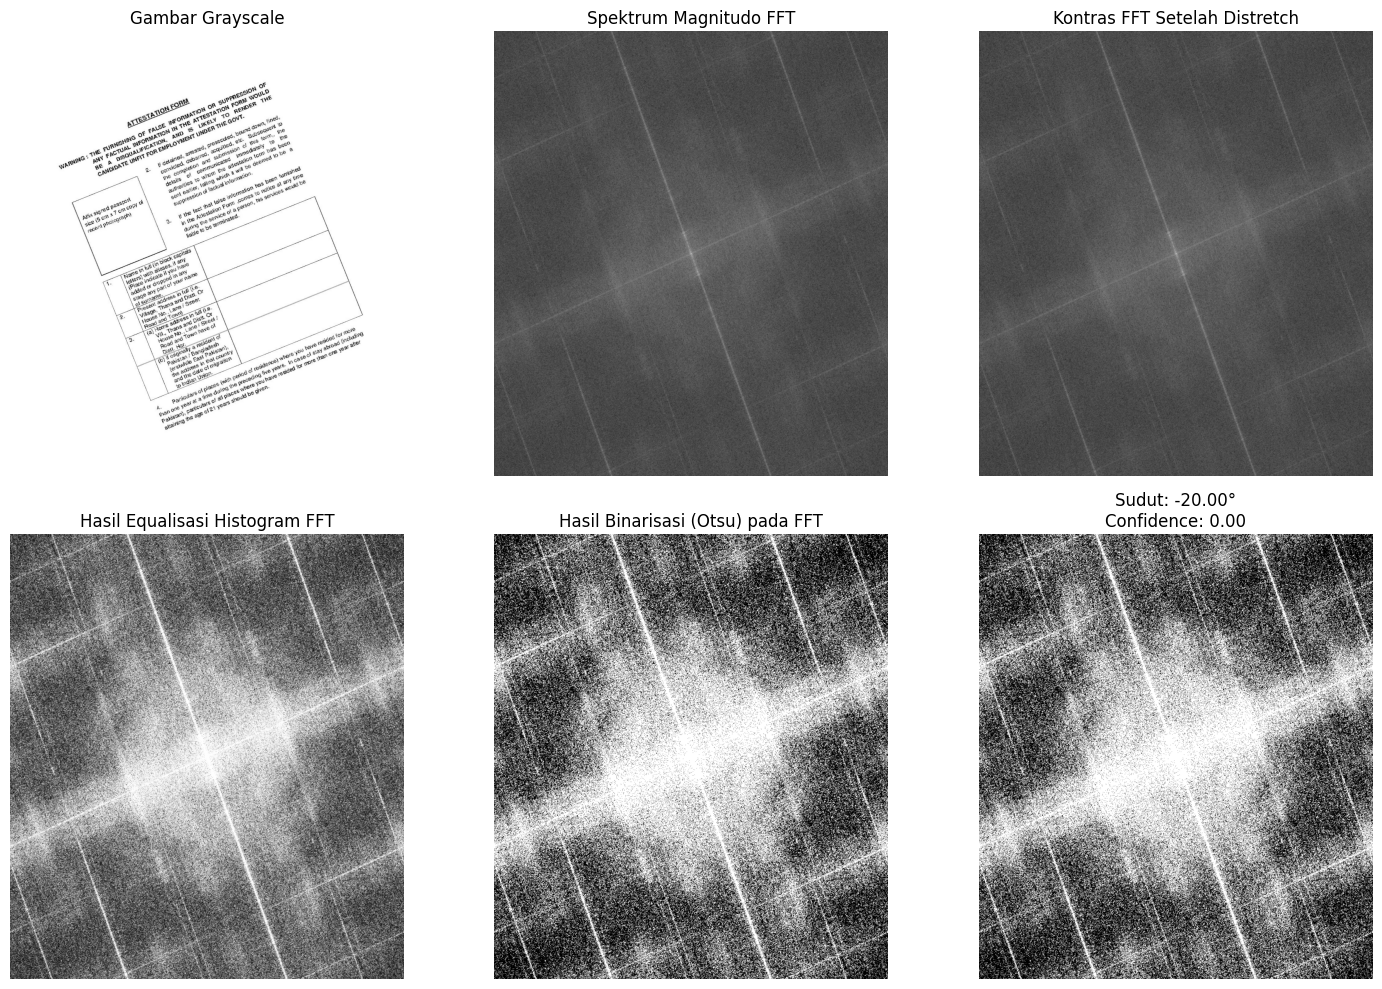

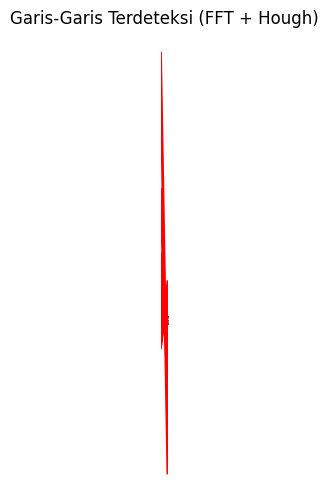

In [84]:
# === VISUALISASI PROSES ===

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Gambar Grayscale")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(magnitude, cmap='gray')
plt.title("Spektrum Magnitudo FFT")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(stretched, cmap='gray')
plt.title("Kontras FFT Setelah Distretch")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(eq, cmap='gray')
plt.title("Hasil Equalisasi Histogram FFT")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(binary_fft, cmap='gray')
plt.title("Hasil Binarisasi (Otsu) pada FFT")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(binary_fft, cmap='gray')
plt.title(f"Sudut: {angle_fft:.2f}°\nConfidence: {confidence_fft:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# === VISUALISASI GARIS HOUGH ===
plt.figure(figsize=(8, 6))
plt.imshow(binary_fft, cmap='gray')
rows, cols = binary_fft.shape

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    try:
        # Tangani kasus dimana sin(angle) mendekati 0
        if np.abs(np.sin(angle)) < 1e-6:  # Hampir horizontal
            x0 = (dist - 0 * np.sin(angle)) / np.cos(angle)
            x1 = (dist - rows * np.sin(angle)) / np.cos(angle)
            plt.plot([x0, x1], [0, rows], '-r', linewidth=2)
        else:
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
            plt.plot([0, cols], [y0, y1], '-r', linewidth=2)
    except:
        continue  # Lewati garis yang tidak bisa diplot

plt.title("Garis-Garis Terdeteksi (FFT + Hough)")
plt.axis('off')
plt.show()

# Deteksi Sudut Kemiringan Menggunakan Projection Profiling

## Konsep Dasar
Metode ini menganalisis distribusi komponen teks untuk menentukan orientasi dokumen dengan memaksimalkan variansi proyeksi vertikal.

## 1. Analisis Komponen Terhubung (Connected Components)

**Tujuan**:  
Mengidentifikasi dan memfilter elemen-elemen teks/karakter dalam dokumen

**Proses**:
- `measure.label`: Mendeteksi semua komponen terhubung
- `regionprops`: Menganalisis properti setiap komponen
- **Filter Ukuran**:
  - Menghilangkan komponen terlalu besar (noise/artefak)
  - Hanya mempertahankan komponen dengan ukuran wajar

**Parameter Kunci**:
- Batas maksimum: 5x rata-rata lebar/tinggi
- Titik referensi: Titik tengah atas dan bawah bounding box

**Output**:
- Jumlah komponen valid
- Contoh titik referensi yang terdeteksi

## 2. Rotasi dan Analisis Variansi

**Mekanisme**:
1. Menguji berbagai sudut rotasi (-90° hingga +90°)
2. Untuk setiap sudut:
   - Memutar titik referensi
   - Membuat histogram proyeksi vertikal
   - Menghitung variansi distribusi

**Indikator Kualitas**:
- Variansi tinggi = distribusi merata (orientasi baik)
- Variansi rendah = distribusi mengumpul (orientasi buruk)

**Optimasi**:
- `np.linspace`: Uji coba 181 sudut berbeda
- Matriks rotasi 2D untuk transformasi koordinat
- Normalisasi terhadap pusat gambar

## 3. Penentuan Sudut Optimal

**Kriteria**:
- Memilih sudut dengan variansi total tertinggi
- Confidence dihitung berdasarkan:
  - Selisih variansi maksimum dengan rata-rata
  - Dinormalisasi dengan standar deviasi

**Interpretasi Confidence**:
- 1.0: Deteksi sangat jelas
- 0.5-0.9: Deteksi cukup baik
- <0.5: Deteksi kurang meyakinkan

## Keunggulan Metode
- **Robust**: Tahan terhadap noise karena menggunakan banyak komponen
- **Presisi**: Akurasi hingga 1° (dari 181 sudut uji)
- **Efektif**: Khusus untuk dokumen teks dengan banyak karakter

## Contoh Output
```
Sudut -45.00°: var_total=1523.21
Sudut -44.00°: var_total=1687.32 (NEW BEST)
[HASIL] Sudut kemiringan terbaik: -2.00°
[HASIL] Confidence: 0.87
```



In [85]:
# === METODE 2: Deteksi Sudut Kemiringan Menggunakan Projection Profiling ===

# Langkah 1: Deteksi komponen terhubung (connected components)
label_img = measure.label(binary_img)
regions = measure.regionprops(label_img)
print(f"[INFO] Jumlah komponen terdeteksi: {len(regions)}")

# Hitung rata-rata lebar dan tinggi kotak pembatas (AABB)
avg_width = np.mean([r.bbox[3] - r.bbox[1] for r in regions])
avg_height = np.mean([r.bbox[2] - r.bbox[0] for r in regions])
print(f"[INFO] Rata-rata lebar AABB: {avg_width:.2f}")
print(f"[INFO] Rata-rata tinggi AABB: {avg_height:.2f}")

# Ambil titik tengah atas dan bawah dari AABB setiap komponen (yang memenuhi syarat)
top_points, bottom_points = [], []
for i, r in enumerate(regions):
    width = r.bbox[3] - r.bbox[1]
    height = r.bbox[2] - r.bbox[0]

    # Filter: hanya komponen yang berukuran wajar.
    if width < 5 * avg_width and height < 5 * avg_height:
        x_center = (r.bbox[1] + r.bbox[3]) / 2
        top_points.append([x_center, r.bbox[0]])
        bottom_points.append([x_center, r.bbox[2]])
        print(f"Komponen {i+1}: width={width:.1f}, height={height:.1f} -> VALID")
    else:
        print(f"Komponen {i+1}: width={width:.1f}, height={height:.1f} -> DIBUANG (terlalu besar)")

print(f"[INFO] Titik valid terdeteksi: {len(top_points)}")
print(f"Contoh 5 titik atas pertama: {top_points[:5]}")
print(f"Contoh 5 titik bawah pertama: {bottom_points[:5]}")

# Langkah 2: Cari sudut kemiringan terbaik dengan memutar titik-titik
variances = []       # Simpan variansi untuk setiap sudut uji
best_angle = 0       # Sudut dengan variansi maksimum
max_var = 0          # Variansi maksimum

# ATUR TEST ANGLE DI SINI!!!
test_angles = np.linspace(-90, 90, 181)
center = np.array(binary_img.shape[::-1]) / 2  # Titik tengah gambar
print(f"\n[PROSES] Mencari sudut terbaik dari {len(test_angles)} sudut uji...")

for angle in test_angles:
    rad = np.deg2rad(angle)
    rot_mat = np.array([[np.cos(rad), -np.sin(rad)],
                        [np.sin(rad),  np.cos(rad)]])

    # Putar titik-titik terhadap pusat gambar
    rotated_top = (np.array(top_points) - center) @ rot_mat.T + center
    rotated_bottom = (np.array(bottom_points) - center) @ rot_mat.T + center

    # Buat histogram terhadap posisi vertikal (baris)
    hist_top, _ = np.histogram(rotated_top[:,1], bins=200, range=(0, binary_img.shape[0]))
    hist_bottom, _ = np.histogram(rotated_bottom[:,1], bins=200, range=(0, binary_img.shape[0]))

    # Hitung variansi dari histogram (semakin besar -> semakin rata sejajar)
    var_top = np.var(hist_top)
    var_bottom = np.var(hist_bottom)
    total_var = var_top + var_bottom
    variances.append(total_var)

    # Simpan sudut terbaik jika variansi tertinggi
    if total_var > max_var:
        max_var = total_var
        best_angle = angle
        print(f"Sudut {angle:6.2f}°: var_total={total_var:.2f} (NEW BEST)")
    else:
        print(f"Sudut {angle:6.2f}°: var_total={total_var:.2f}")

# Hitung confidence (tingkat keyakinan), semakin tinggi semakin yakin
mean_var = np.mean(variances)
std_var = np.std(variances)
confidence_proj = min(1.0, (max_var - mean_var) / (std_var + 1e-6))  # Hindari pembagian 0
angle_proj = best_angle

[INFO] Jumlah komponen terdeteksi: 1382
[INFO] Rata-rata lebar AABB: 10.12
[INFO] Rata-rata tinggi AABB: 10.53
Komponen 1: width=10.0, height=16.0 -> VALID
Komponen 2: width=14.0, height=14.0 -> VALID
Komponen 3: width=14.0, height=16.0 -> VALID
Komponen 4: width=30.0, height=22.0 -> VALID
Komponen 5: width=14.0, height=15.0 -> VALID
Komponen 6: width=13.0, height=13.0 -> VALID
Komponen 7: width=14.0, height=14.0 -> VALID
Komponen 8: width=14.0, height=15.0 -> VALID
Komponen 9: width=14.0, height=15.0 -> VALID
Komponen 10: width=14.0, height=14.0 -> VALID
Komponen 11: width=24.0, height=20.0 -> VALID
Komponen 12: width=17.0, height=17.0 -> VALID
Komponen 13: width=13.0, height=14.0 -> VALID
Komponen 14: width=14.0, height=15.0 -> VALID
Komponen 15: width=11.0, height=14.0 -> VALID
Komponen 16: width=16.0, height=17.0 -> VALID
Komponen 17: width=19.0, height=18.0 -> VALID
Komponen 18: width=11.0, height=13.0 -> VALID
Komponen 19: width=25.0, height=20.0 -> VALID
Komponen 20: width=14.0,

In [86]:
print("\n=== HASIL PERHITUNGAN ===")
print(f"Sudut dengan variansi tertinggi: {angle_proj:.2f}°")
print(f"Variansi maksimum: {max_var:.2f}")
print(f"Rata-rata variansi semua sudut: {mean_var:.2f}")
print(f"Standar deviasi variansi: {std_var:.2f}")
print(f"[HASIL] Sudut kemiringan terbaik (Projection Profiling): {angle_proj:.2f}°")
print(f"[HASIL] Confidence hasil deteksi: {confidence_proj:.2f}")


=== HASIL PERHITUNGAN ===
Sudut dengan variansi tertinggi: 22.00°
Variansi maksimum: 259.95
Rata-rata variansi semua sudut: 98.80
Standar deviasi variansi: 36.10
[HASIL] Sudut kemiringan terbaik (Projection Profiling): 22.00°
[HASIL] Confidence hasil deteksi: 1.00


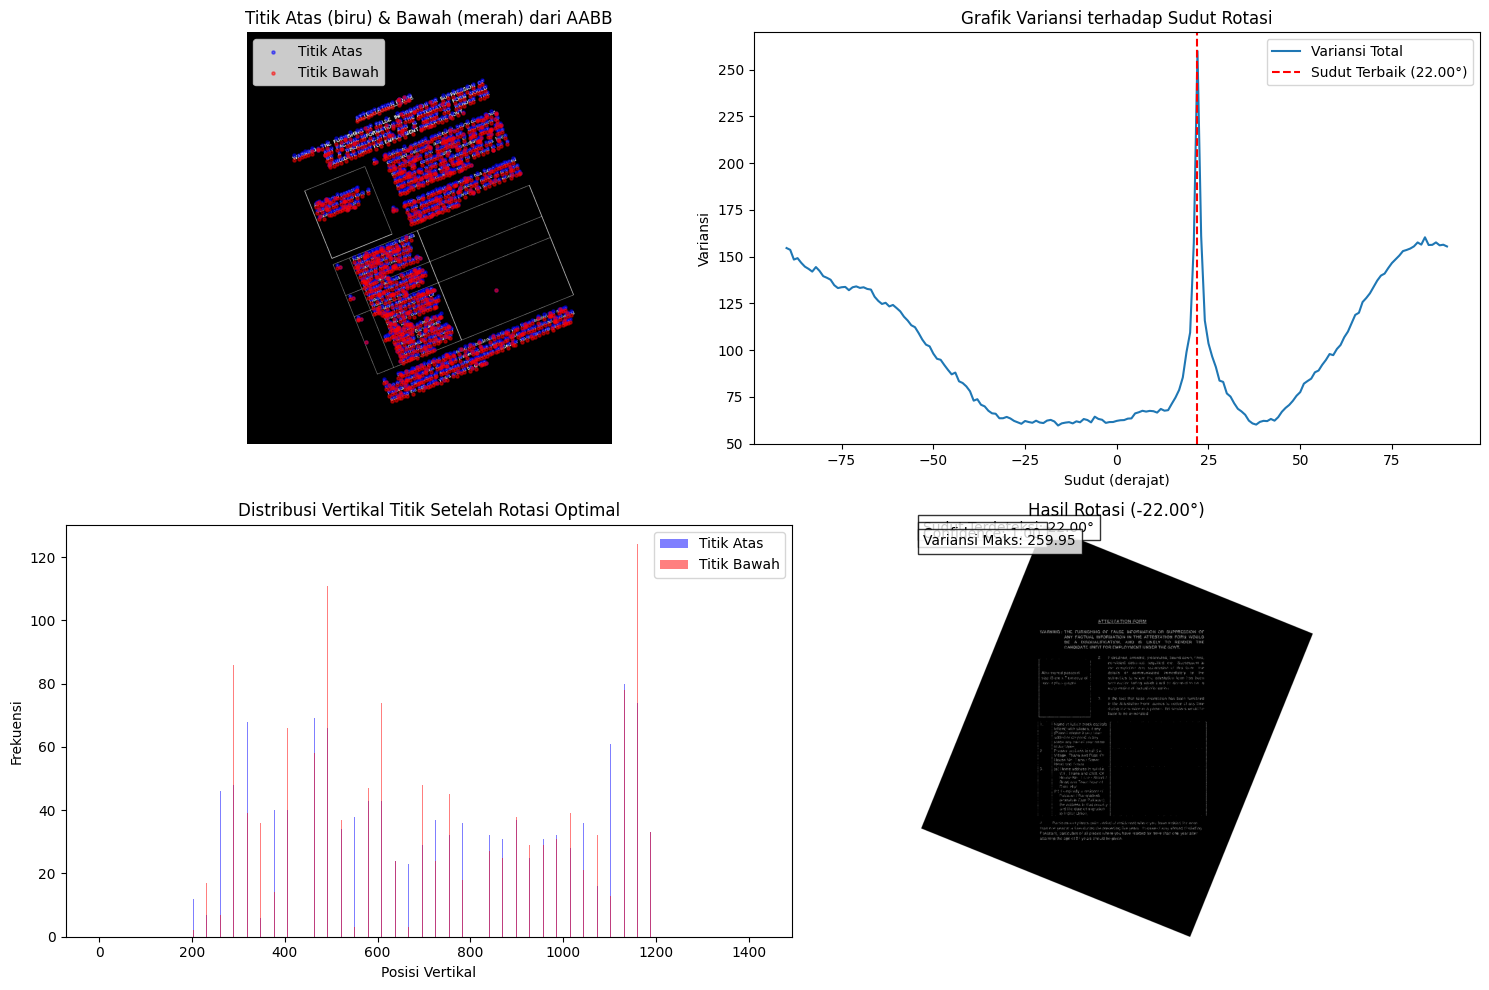

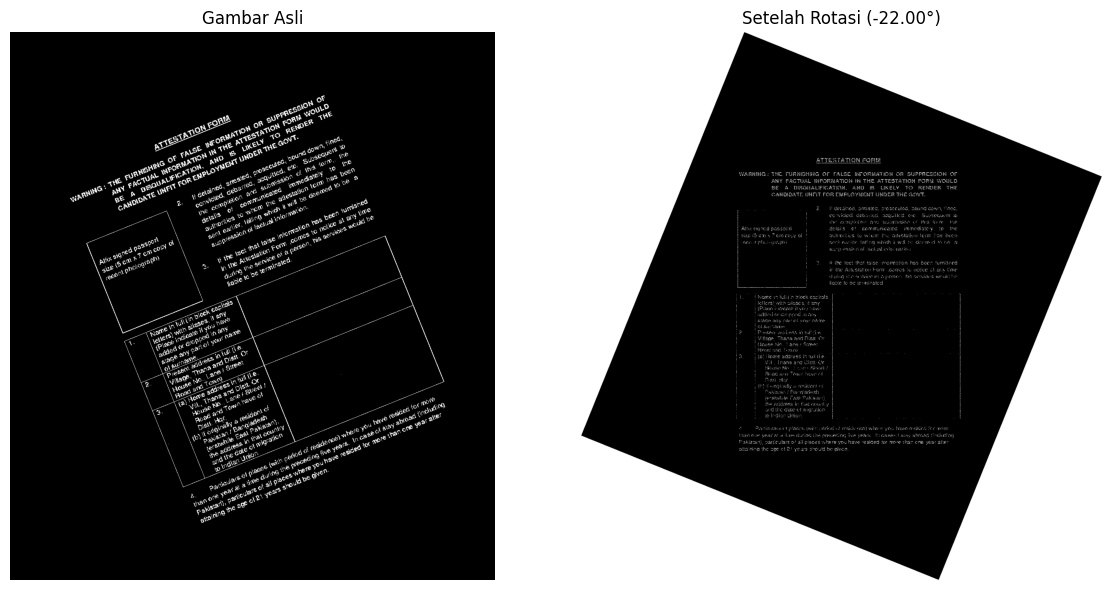

In [87]:
# === VISUALISASI HASIL ===
plt.figure(figsize=(15, 10))

# Plot 1: Titik-titik yang digunakan pada gambar asli
plt.subplot(2, 2, 1)
plt.imshow(binary_img, cmap='gray')
plt.scatter([p[0] for p in top_points], [p[1] for p in top_points], c='blue', s=5, alpha=0.5, label='Titik Atas')
plt.scatter([p[0] for p in bottom_points], [p[1] for p in bottom_points], c='red', s=5, alpha=0.5, label='Titik Bawah')
plt.title("Titik Atas (biru) & Bawah (merah) dari AABB")
plt.axis('off')
plt.legend()

# Plot 2: Grafik variansi terhadap sudut
plt.subplot(2, 2, 2)
angles_tested = np.linspace(-90, 90, 181)
plt.plot(angles_tested, variances, label='Variansi Total')
plt.axvline(x=angle_proj, color='r', linestyle='--', label=f'Sudut Terbaik ({angle_proj:.2f}°)')
plt.xlabel('Sudut (derajat)')
plt.ylabel('Variansi')
plt.title('Grafik Variansi terhadap Sudut Rotasi')
plt.legend()

# Plot 3: Histogram posisi vertikal setelah rotasi optimal
plt.subplot(2, 2, 3)
rad = np.deg2rad(angle_proj)
rot_mat = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
rotated_top = (np.array(top_points) - center) @ rot_mat.T + center
rotated_bottom = (np.array(bottom_points) - center) @ rot_mat.T + center

hist_top, bins = np.histogram(rotated_top[:,1], bins=50, range=(0, binary_img.shape[0]))
hist_bottom, _ = np.histogram(rotated_bottom[:,1], bins=50, range=(0, binary_img.shape[0]))

plt.bar(bins[:-1], hist_top, width=2, color='blue', alpha=0.5, label='Titik Atas')
plt.bar(bins[:-1], hist_bottom, width=2, color='red', alpha=0.5, label='Titik Bawah')
plt.title('Distribusi Vertikal Titik Setelah Rotasi Optimal')
plt.xlabel('Posisi Vertikal')
plt.ylabel('Frekuensi')
plt.legend()

# Plot 4: Hasil rotasi dan informasi teks
plt.subplot(2, 2, 4)
rotated_img = rotate(binary_img, -angle_proj, reshape=True, mode='constant', cval=1)
plt.imshow(rotated_img, cmap='gray')
plt.title(f"Hasil Rotasi ({-angle_proj:.2f}°)")
plt.axis('off')

# Tambahkan info teks di dalam plot
plt.text(10, 30, f"Sudut Terdeteksi: {angle_proj:.2f}°",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(10, 60, f"Confidence: {confidence_proj:.2f}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(10, 90, f"Variansi Maks: {max_var:.2f}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Visualisasi tambahan: Perbandingan sebelum dan sesudah rotasi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(binary_img, cmap='gray')
plt.title("Gambar Asli")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rotated_img, cmap='gray')
plt.title(f"Setelah Rotasi ({-angle_proj:.2f}°)")
plt.axis('off')

plt.tight_layout()
plt.show()

# METODE 3 SPATIAL DOMAIN LINES (HOUGH BASED)

In [88]:
# === METODE 3: Spatial Domain Lines (Hough-based) ===

# 1. PROSES DETEKSI TEPI
# Deteksi tepi menggunakan filter Sobel
print("\n=== PROSES DETEKSI TEPI ===")
edges = sobel(img_gray)
print("1. Hasil filter Sobel - Nilai pixel berupa float [0-1]")
edges = img_as_ubyte(edges)
print("2. Konversi ke format uint8 [0-255] untuk thresholding")
# Binarisasi tepi menggunakan threshold Otsu
edges_binary = edges > threshold_otsu(edges)
print(f"3. Binarisasi dengan threshold Otsu (nilai threshold: {threshold_otsu(edges)})")

# 2. TRANSFORMASI HOUGH
# Mengubah representasi garis dari domain spasial (x,y) ke parameter (θ,d)
# Setiap garis lurus direpresentasikan sebagai titik dalam Hough space
# Akumulator voting space (h), array sudut yang diuji (theta), array jarak dari origin (d)
print("\n=== TRANSFORMASI HOUGH ===")
h, theta, d = hough_line(edges_binary)
print("4. Transformasi Hough selesai:")
print(f"   - Dimensi Hough space: {h.shape}")
print(f"   - Jumlah sudut theta yang diuji: {len(theta)}")
print(f"   - Jumlah nilai d (jarak): {len(d)}")

# 3. DETEKSI PUNCAK (PEAK DETECTION)
# min_distance (jarak antar peak) dan min_angle (perbedaan sudut minimum)
_, angles, dists = hough_line_peaks(h, theta, d, min_distance=20, min_angle=5)
angles_deg = np.rad2deg(angles)
print("\n5. Peak detection dalam Hough space:")
print(f"   - Jumlah garis terdeteksi: {len(angles)}")
print(f"   - Sudut (radian): {angles}")
print(f"   - Sudut (derajat): {angles_deg}")
print(f"   - Jarak (d): {dists}")

# 4. PENGELOMPOKKAN GARIS MENJADI SET-SET PARALEL
print("\n=== PENGELOMPOKAN GARIS PARALEL ===")
parallel_sets = []
for angle, dist in zip(angles_deg, dists):
    matched = False
    for s in parallel_sets:
        # Cek apakah sudut mirip (dalam toleransi 5 derajat)
        if abs(s[0][0] - angle) < 5:
            s.append((angle, dist))
            matched = True
            break
    if not matched:
        parallel_sets.append([(angle, dist)])

print(f"6. Hasil pengelompokan garis paralel:")
print(f"   - Jumlah kelompok paralel: {len(parallel_sets)}")
for i, s in enumerate(parallel_sets):
    print(f"   - Kelompok {i+1}: {len(s)} garis, sudut: {[x[0] for x in s]}")

# Menghitung sudut representatif untuk setiap kelompok
print("\n=== PERHITUNGAN SUDUT DOMINAN ===")
set_angles = []
set_lengths = []
for s in parallel_sets:
    avg_angle = np.mean([a for a, _ in s])
    set_angles.append(avg_angle)
    set_lengths.append(len(s))  # Jumlah garis sebagai proxy panjang total
    print(f"7. Kelompok dengan {len(s)} garis - sudut rata-rata: {avg_angle:.2f}°")

# Mencari sudut dominan (seperti pada paper)
print("\n=== PENENTUAN SUDUT DAN KONFIDENSI AKHIR ===")
if len(set_angles) == 0:
    angle_hough = 0.0
    confidence_hough = 0.0
    print("8. Tidak ada garis terdeteksi, menggunakan nilai default")
else:
    # Urutkan kelompok berdasarkan ukuran (jumlah garis)
    sorted_sets = sorted(zip(set_angles, set_lengths), key=lambda x: -x[1])
    print(f"9. Kelompok terurut berdasarkan jumlah garis:")
    for i, (angle, length) in enumerate(sorted_sets):
        print(f"   - Peringkat {i+1}: sudut {angle:.2f}° dengan {length} garis")

    # Kasus 1: Hanya satu kelompok
    if len(sorted_sets) == 1:
        angle_hough = sorted_sets[0][0]
        confidence_hough = min(1.0, sorted_sets[0][1] / 20)
        print(f"10. Kasus 1 - Hanya satu kelompok dominan:")
        print(f"    - Sudut akhir: {angle_hough:.2f}°")
        print(f"    - Konfidensi: {confidence_hough:.2f} (berdasarkan jumlah garis)")

    # Kasus 2: Beberapa kelompok, cari pasangan tegak lurus
    else:
        main_angle = sorted_sets[0][0]
        print(f"10. Kasus 2 - Mencari pasangan tegak lurus untuk sudut utama {main_angle:.2f}°")

        # Cari sudut yang paling tegak lurus (selisih terdekat ke 90°)
        perpendicular_diff = []
        for angle, length in sorted_sets[1:]:
            diff = abs(abs(angle - main_angle) - 90)
            perpendicular_diff.append((diff, angle, length))
            print(f"    - Bandingkan dengan {angle:.2f}°, selisih {diff:.2f}° dari 90°")

        if perpendicular_diff:
            best_diff, best_angle, best_length = min(perpendicular_diff, key=lambda x: x[0])
            print(f"    - Sudut paling tegak lurus: {best_angle:.2f}° (selisih {best_diff:.2f}°)")

            if best_diff < 15:  # Toleransi 15° untuk tegak lurus
                # Rata-rata berbobot
                total_weight = sorted_sets[0][1] + best_length
                angle_hough = (main_angle * sorted_sets[0][1] + best_angle * best_length) / total_weight
                confidence_hough = min(1.0, (sorted_sets[0][1] + best_length) / 30 * (1 - best_diff/90))
                print(f"11. Pasangan tegak lurus valid:")
                print(f"    - Sudut akhir (rata-rata berbobot): {angle_hough:.2f}°")
                print(f"    - Konfidensi: {confidence_hough:.2f}")
            else:
                angle_hough = main_angle
                confidence_hough = min(1.0, sorted_sets[0][1] / 20)
                print(f"11. Tidak ada pasangan tegak lurus yang valid:")
                print(f"    - Sudut akhir: {angle_hough:.2f}° (hanya menggunakan kelompok utama)")
                print(f"    - Konfidensi: {confidence_hough:.2f}")
        else:
            angle_hough = main_angle
            confidence_hough = min(1.0, sorted_sets[0][1] / 20)
            print(f"11. Tidak ada kelompok lain untuk dibandingkan:")
            print(f"    - Sudut akhir: {angle_hough:.2f}°")
            print(f"    - Konfidensi: {confidence_hough:.2f}")


=== PROSES DETEKSI TEPI ===
1. Hasil filter Sobel - Nilai pixel berupa float [0-1]
2. Konversi ke format uint8 [0-255] untuk thresholding
3. Binarisasi dengan threshold Otsu (nilai threshold: 60)

=== TRANSFORMASI HOUGH ===
4. Transformasi Hough selesai:
   - Dimensi Hough space: (3875, 180)
   - Jumlah sudut theta yang diuji: 180
   - Jumlah nilai d (jarak): 3875

5. Peak detection dalam Hough space:
   - Jumlah garis terdeteksi: 27
   - Sudut (radian): [ 1.18682389  1.18682389  1.18682389 -0.38397244  1.18682389  1.18682389
  1.18682389  1.18682389 -0.38397244  1.18682389  1.18682389 -0.38397244
  1.18682389 -0.38397244  1.18682389 -0.38397244  1.18682389  0.06981317
 -0.08726646  0.01745329  0.10471976 -0.78539816  0.17453293  0.19198622
 -0.78539816 -0.08726646  0.78539816]
   - Sudut (derajat): [ 68.  68.  68. -22.  68.  68.  68.  68. -22.  68.  68. -22.  68. -22.
  68. -22.  68.   4.  -5.   1.   6. -45.  10.  11. -45.  -5.  45.]
   - Jarak (d): [ 871. 1069.  989.  292.  593. 136


=== VISUALISASI HASIL ===


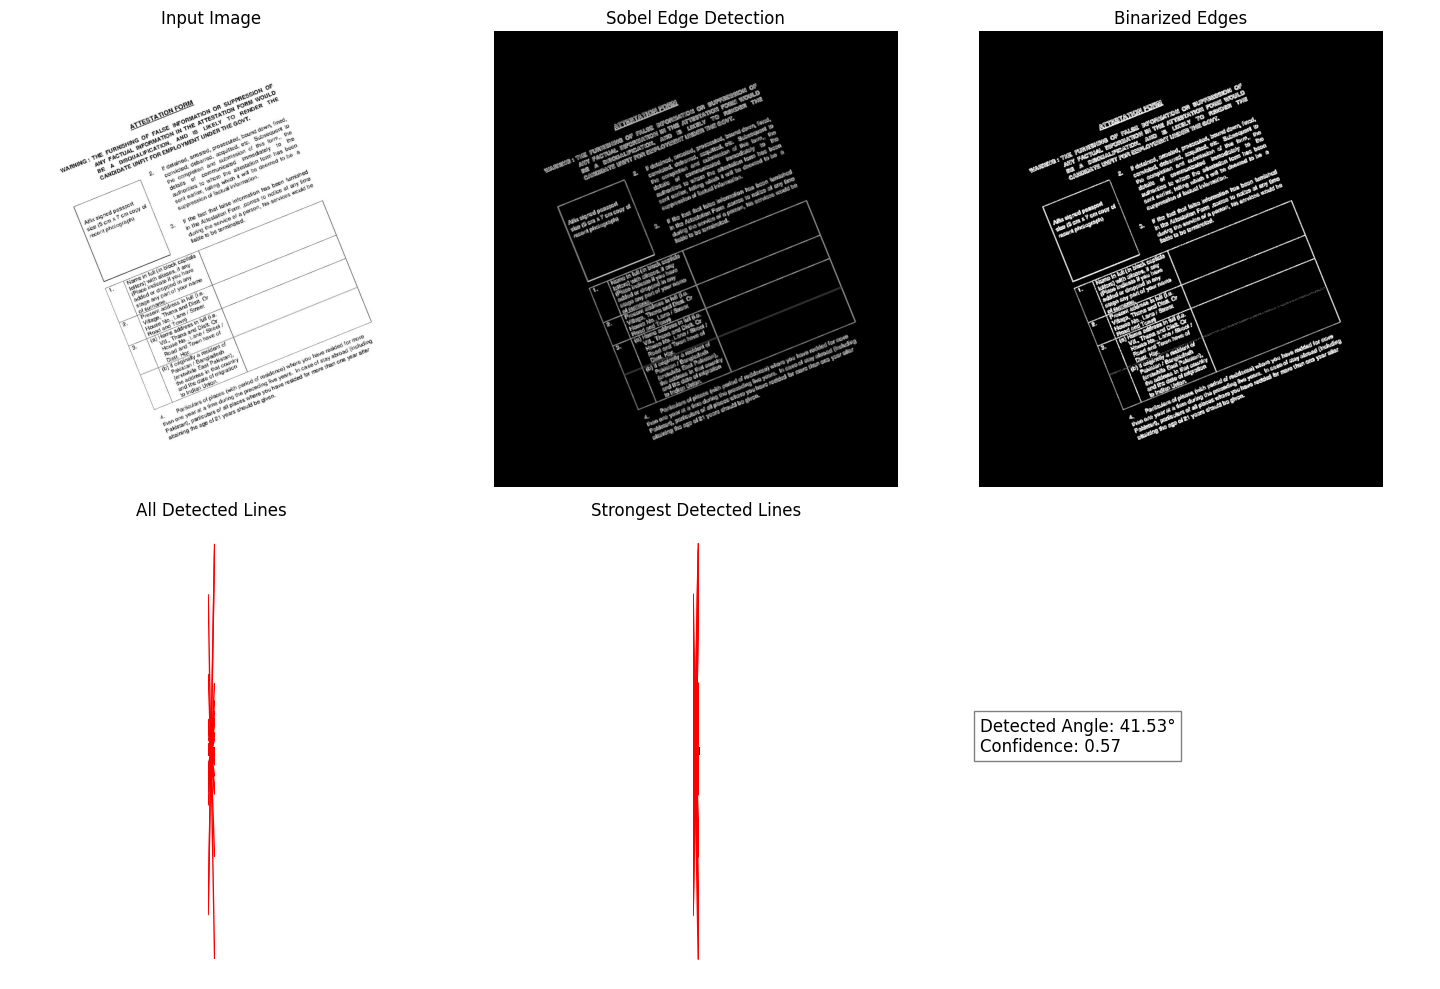

In [89]:
# Visualisasi hasil
print("\n=== VISUALISASI HASIL ===")
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(edges_binary, cmap='gray')
plt.title("Binarized Edges")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(edges_binary, cmap='gray')
rows, cols = edges_binary.shape

# Gambar semua garis terdeteksi
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r', linewidth=1)

plt.title("All Detected Lines")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(edges_binary, cmap='gray')

# Gambar hanya garis terkuat
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=0.5*np.max(h))):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r', linewidth=2)

plt.title("Strongest Detected Lines")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.text(0.1, 0.5, f"Detected Angle: {angle_hough:.2f}°\nConfidence: {confidence_hough:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.axis('off')

plt.tight_layout()
plt.show()

In [90]:
# Daftar kandidat metode yang memenuhi syarat
candidates = []

# Menambahkan kandidat dengan confidence cukup (threshold = 0.5 sesuai paper)
print("\n1. Seleksi Awal Kandidat (confidence >= 0.5):")
if confidence_fft >= 0.5:
    candidates.append(('FFT', angle_fft, confidence_fft))
    print(f"   - Metode FFT ditambahkan: Sudut {angle_fft:.2f}°, Confidence {confidence_fft:.2f}")
else:
    print(f"   - Metode FFT tidak memenuhi syarat (confidence {confidence_fft:.2f} < 0.5)")

if confidence_proj >= 0.5:
    candidates.append(('Projection', angle_proj, confidence_proj))
    print(f"   - Metode Projection ditambahkan: Sudut {angle_proj:.2f}°, Confidence {confidence_proj:.2f}")
else:
    print(f"   - Metode Projection tidak memenuhi syarat (confidence {confidence_proj:.2f} < 0.5)")

if confidence_hough >= 0.5:
    candidates.append(('Hough', angle_hough, confidence_hough))
    print(f"   - Metode Hough ditambahkan: Sudut {angle_hough:.2f}°, Confidence {confidence_hough:.2f}")
else:
    print(f"   - Metode Hough tidak memenuhi syarat (confidence {confidence_hough:.2f} < 0.5)")

# Cetak seluruh kandidat yang memenuhi syarat
print("\n2. Daftar Kandidat yang Memenuhi Syarat:")
if candidates:
    for i, (method, angle, conf) in enumerate(candidates, 1):
        print(f"   {i}. {method}: Sudut {angle:.2f}°, Confidence {conf:.2f}")
else:
    print("   - Tidak ada kandidat yang memenuhi syarat")

# Jika tidak ada kandidat
if not candidates:
    final_angle_best = None
    final_angle_weighted = None
    best_method = None
    final_confidence = 0.0
    print("\n3. Voting Dibatalkan:")
    print("   - Semua metode memiliki confidence < 0.5")
else:
    print("\n3. Proses Voting:")

    # === Best-First Voting ===
    print("   - Best First Voting (pilih metode dengan confidence tertinggi)")
    best_first = max(candidates, key=lambda x: x[2])
    final_angle_best = best_first[1]
    best_method = best_first[0]
    final_confidence = best_first[2]
    print(f"     -> Pemenang: {best_method}, Sudut: {final_angle_best:.2f}°, Confidence: {final_confidence:.2f}")

    # === Weighted Voting ===
    print("   - Weighted Voting (rata-rata berbobot oleh confidence)")
    weighted_sum = sum(angle * conf for _, angle, conf in candidates)
    total_conf = sum(conf for _, _, conf in candidates)
    final_angle_weighted = weighted_sum / total_conf if total_conf > 0 else 0
    weighted_confidence = total_conf / len(candidates)
    print(f"     -> Sudut rata-rata berbobot: {final_angle_weighted:.2f}° (dari total confidence: {total_conf:.2f})")


1. Seleksi Awal Kandidat (confidence >= 0.5):
   - Metode FFT tidak memenuhi syarat (confidence 0.00 < 0.5)
   - Metode Projection ditambahkan: Sudut 22.00°, Confidence 1.00
   - Metode Hough ditambahkan: Sudut 41.53°, Confidence 0.57

2. Daftar Kandidat yang Memenuhi Syarat:
   1. Projection: Sudut 22.00°, Confidence 1.00
   2. Hough: Sudut 41.53°, Confidence 0.57

3. Proses Voting:
   - Best First Voting (pilih metode dengan confidence tertinggi)
     -> Pemenang: Projection, Sudut: 22.00°, Confidence: 1.00
   - Weighted Voting (rata-rata berbobot oleh confidence)
     -> Sudut rata-rata berbobot: 29.06° (dari total confidence: 1.57)



=== HASIL AKHIR DETEKSI SUDUT KEMIRINGAN ===

--- Best-First Voting ---
Metode Terpilih         : Projection
Sudut Terdeteksi        : 22.00°
Tingkat Kepercayaan     : 1.00

--- Weighted Voting ---
Sudut Rata-rata Berbobot: 29.06°
Rata-rata Confidence    : 0.78


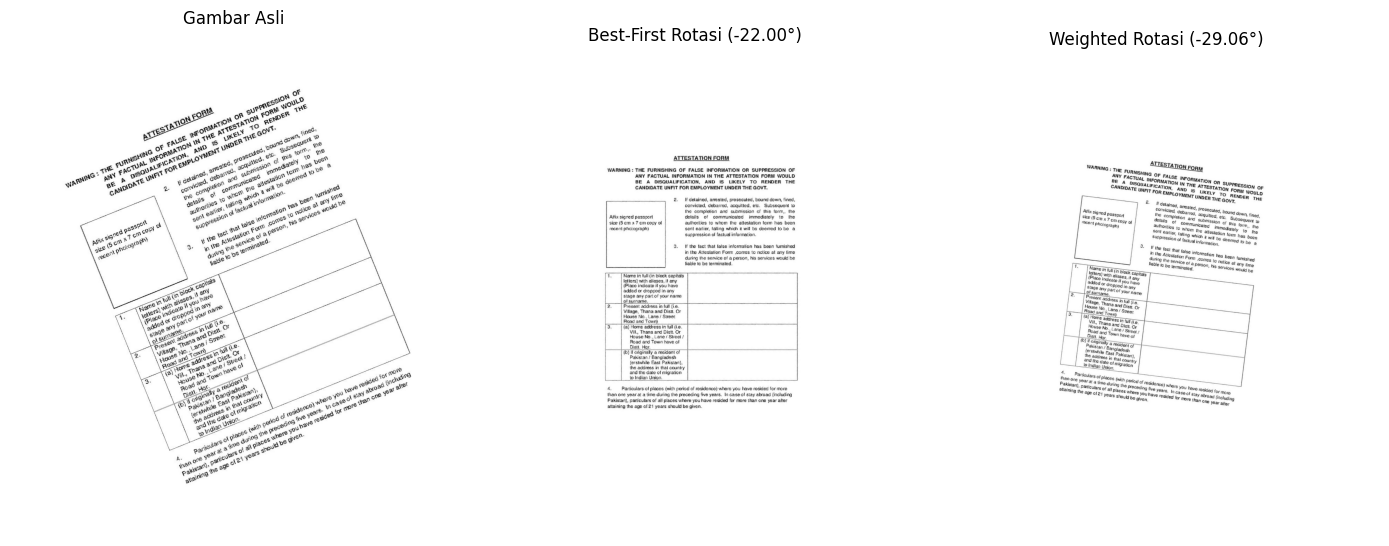

In [91]:
# === MENAMPILKAN HASIL AKHIR ===

if final_angle_best is not None:
    print("\n=== HASIL AKHIR DETEKSI SUDUT KEMIRINGAN ===")

    print("\n--- Best-First Voting ---")
    print(f"Metode Terpilih         : {best_method}")
    print(f"Sudut Terdeteksi        : {final_angle_best:.2f}°")
    print(f"Tingkat Kepercayaan     : {final_confidence:.2f}")

    print("\n--- Weighted Voting ---")
    print(f"Sudut Rata-rata Berbobot: {final_angle_weighted:.2f}°")
    print(f"Rata-rata Confidence    : {weighted_confidence:.2f}")

    # Menampilkan gambar hasil koreksi dari Best-First
    corrected_best = rotate(img, -final_angle_best, reshape=True, mode='constant', cval=255)
    corrected_weighted = rotate(img, -final_angle_weighted, reshape=True, mode='constant', cval=255)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Gambar Asli")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_best)
    plt.title(f"Best-First Rotasi ({-final_angle_best:.2f}°)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(corrected_weighted)
    plt.title(f"Weighted Rotasi ({-final_angle_weighted:.2f}°)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("\nTidak terdeteksi sudut kemiringan yang andal (semua metode confidence < 0.5)")
    print("Saran: Gunakan gambar dengan kualitas lebih baik atau preprocessing tambahan.")


In [92]:
import re
import math

# === FUNGSI EKSTRAK SUDUT DARI NAMA FILE ===
def extract_gt_angle_from_filename(filename):
    match = re.search(r'Image-\d+-(-?-?\d+)', filename)
    if match:
        try:
            return int(match.group(1))
        except:
            return None
    return None

# === DAPATKAN GROUND TRUTH ===
gt_angle = extract_gt_angle_from_filename(image_path)

# === FUNGSI BANTU UNTUK EVALUASI AKURASI ===
def evaluate_accuracy(method_name, predicted_angle, gt_angle):
    error_abs = abs(predicted_angle - gt_angle)
    error_sq = (predicted_angle - gt_angle) ** 2
    error_rmse = math.sqrt(error_sq)
    acc_1 = error_abs <= 1.0
    acc_2 = error_abs <= 2.0
    acc_5 = error_abs <= 5.0

    print(f"\n=== EVALUASI AKURASI: {method_name} ===")
    print(f"Sudut Ground Truth      : {gt_angle} derajat")
    print(f"Sudut Terdeteksi        : {predicted_angle:.2f} derajat")
    print(f"Error Absolut (MAE)     : {error_abs:.2f} derajat")
    print(f"Error Kuadrat           : {error_sq:.4f}")
    print(f"Root Mean Squared Error : {error_rmse:.4f}")
    print("\nAkurasi Berdasarkan Ambang:")
    print(f"- Akurat <= 1 derajat   : {'YA' if acc_1 else 'TIDAK'}")
    print(f"- Akurat <= 2 derajat   : {'YA' if acc_2 else 'TIDAK'}")
    print(f"- Akurat <= 5 derajat   : {'YA' if acc_5 else 'TIDAK'}")

    print("\nStatus Evaluasi:")
    if acc_2:
        print("DETEKSI DINYATAKAN AKURAT (PASS)")
    else:
        print("DETEKSI DINYATAKAN TIDAK AKURAT (FAIL)")

# === JALANKAN EVALUASI UNTUK KEDUA METODE ===
if gt_angle is not None:
    if final_angle_best is not None:
        evaluate_accuracy("Best-First Voting", final_angle_best, gt_angle)
    if final_angle_weighted is not None:
        evaluate_accuracy("Weighted Voting", final_angle_weighted, gt_angle)
else:
    print("\n[Peringatan] Ground truth sudut tidak dapat diambil dari nama file.")
    print("Pastikan nama file sesuai format: Image-12--45Image_xxx.jpg (artinya +45 derajat).")


=== EVALUASI AKURASI: Best-First Voting ===
Sudut Ground Truth      : 22 derajat
Sudut Terdeteksi        : 22.00 derajat
Error Absolut (MAE)     : 0.00 derajat
Error Kuadrat           : 0.0000
Root Mean Squared Error : 0.0000

Akurasi Berdasarkan Ambang:
- Akurat <= 1 derajat   : YA
- Akurat <= 2 derajat   : YA
- Akurat <= 5 derajat   : YA

Status Evaluasi:
DETEKSI DINYATAKAN AKURAT (PASS)

=== EVALUASI AKURASI: Weighted Voting ===
Sudut Ground Truth      : 22 derajat
Sudut Terdeteksi        : 29.06 derajat
Error Absolut (MAE)     : 7.06 derajat
Error Kuadrat           : 49.8977
Root Mean Squared Error : 7.0638

Akurasi Berdasarkan Ambang:
- Akurat <= 1 derajat   : TIDAK
- Akurat <= 2 derajat   : TIDAK
- Akurat <= 5 derajat   : TIDAK

Status Evaluasi:
DETEKSI DINYATAKAN TIDAK AKURAT (FAIL)
